# Fetch ML Engineer Take Home Excecise
## Exploratory Data Analysis
downloading the data

In [5]:
import pandas as pd
data = pd.read_csv('https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv')
data

### Monthly counts for reciepts

<Axes: xlabel='month'>

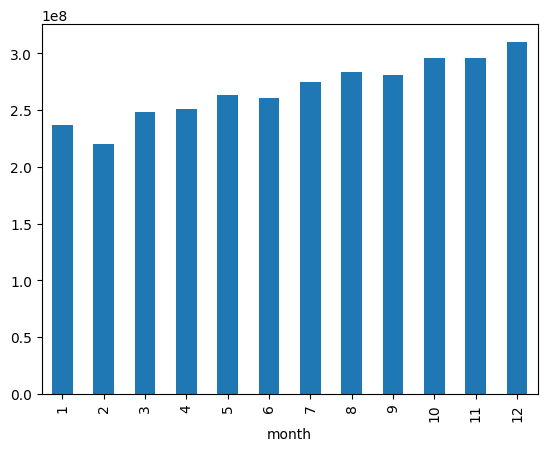

In [7]:
# plot the data for each month

data['# Date'] = pd.to_datetime(data['# Date'])
data['month'] = data['# Date'].dt.month

data.groupby('month')['Receipt_Count'].sum().plot(kind='bar')

## Monthly counts with days of the week

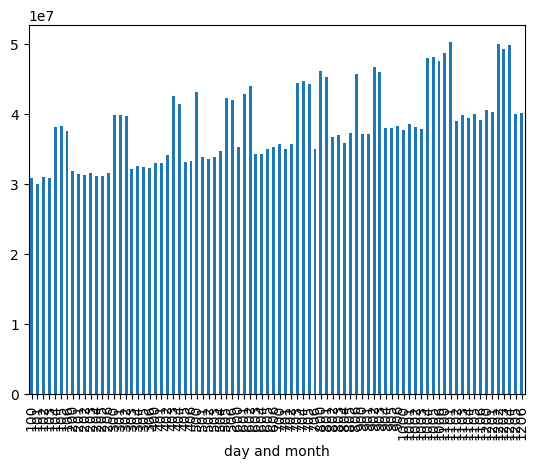

In [8]:
# plot each week days 

data['day'] = data['# Date'].dt.dayofweek
data['day and month'] = (data['month'].astype(int)*100) + data['day'].astype(int)
# do a big plot
data.groupby('day and month')['Receipt_Count'].sum().plot(kind='bar')
# increase the size of the plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

## Model testing in pytorch

In [9]:
import torch

# store monthly values in a tensor
y = torch.tensor(data.groupby('month')['Receipt_Count'].sum().values, dtype=torch.float32)
x = torch.tensor(data.groupby('month')['Receipt_Count'].sum().index, dtype=torch.float32)

In [10]:
def do_model(degree, epochs = 10000, lr = 0.01):
    w = [torch.zeros(1, requires_grad=True) for i in range(degree)]

    b = torch.zeros(1, requires_grad=True)
    # use adam
    optimizer = torch.optim.SGD(w+[ b], lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        y_hat = sum([w[i] * x ** (i + 1) for i in range(degree)]) + b
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    w_final = [w[i].item() for i in range(degree)]
    b_final = b.item()
    plt.plot(x, y, 'o')
    plt.plot(x, sum([w_final[i] * x ** (i + 1) for i in range(degree)]) + b_final)
    plt.xticks(range(1, 13))
    plt.show()

### Linear model with stochastic gradiend descent

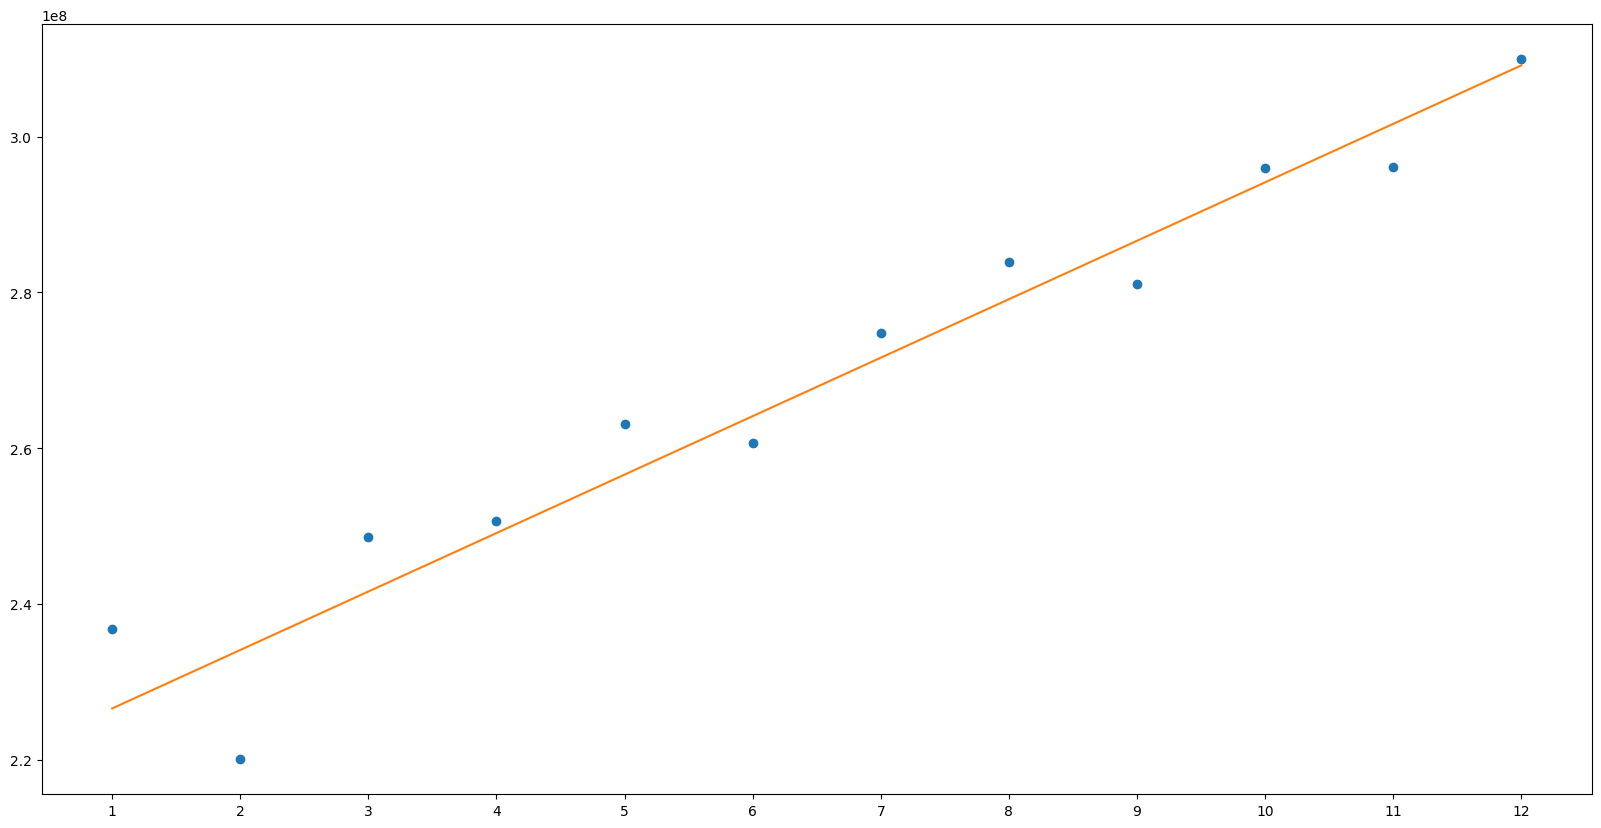

In [11]:
do_model(1, epochs=1000, lr=0.01)

### Linear model using normal equation to calculate weights

tensor([[ 1.,  1.],
        [ 1.,  2.],
        [ 1.,  3.],
        [ 1.,  4.],
        [ 1.,  5.],
        [ 1.,  6.],
        [ 1.,  7.],
        [ 1.,  8.],
        [ 1.,  9.],
        [ 1., 10.],
        [ 1., 11.],
        [ 1., 12.]])


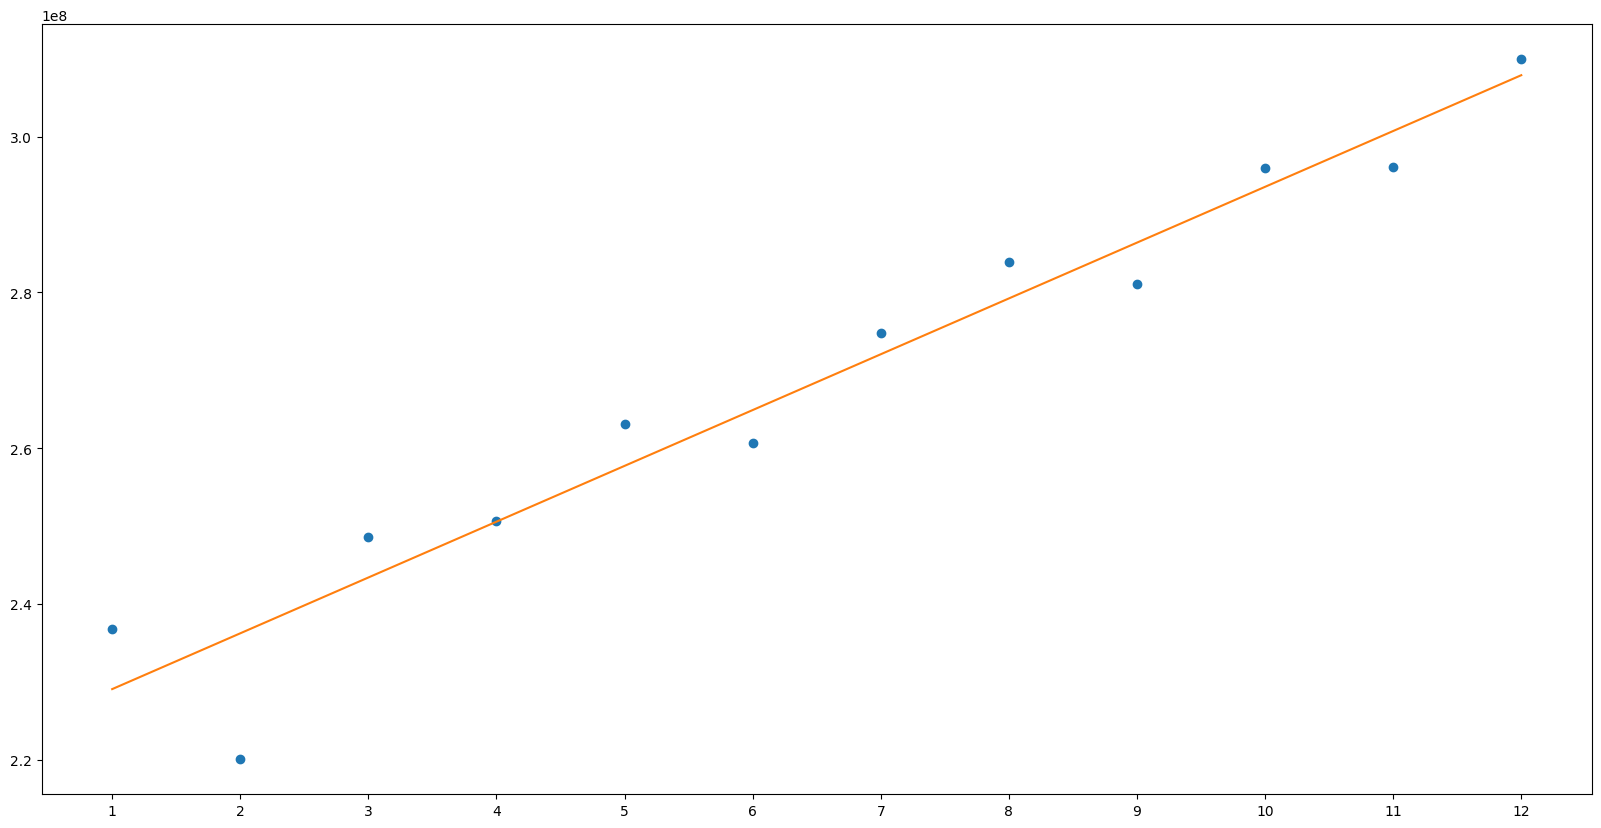

6353774.5
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00, 1.6000e+01, 3.2000e+01],
        [1.0000e+00, 3.0000e+00, 9.0000e+00, 2.7000e+01, 8.1000e+01, 2.4300e+02],
        [1.0000e+00, 4.0000e+00, 1.6000e+01, 6.4000e+01, 2.5600e+02, 1.0240e+03],
        [1.0000e+00, 5.0000e+00, 2.5000e+01, 1.2500e+02, 6.2500e+02, 3.1250e+03],
        [1.0000e+00, 6.0000e+00, 3.6000e+01, 2.1600e+02, 1.2960e+03, 7.7760e+03],
        [1.0000e+00, 7.0000e+00, 4.9000e+01, 3.4300e+02, 2.4010e+03, 1.6807e+04],
        [1.0000e+00, 8.0000e+00, 6.4000e+01, 5.1200e+02, 4.0960e+03, 3.2768e+04],
        [1.0000e+00, 9.0000e+00, 8.1000e+01, 7.2900e+02, 6.5610e+03, 5.9049e+04],
        [1.0000e+00, 1.0000e+01, 1.0000e+02, 1.0000e+03, 1.0000e+04, 1.0000e+05],
        [1.0000e+00, 1.1000e+01, 1.2100e+02, 1.3310e+03, 1.4641e+04, 1.6105e+05],
        [1.0000e+00, 1.2000e+01, 1.4400e+02, 1.7280e+03, 2.0736e+04, 2.4883e+05]])


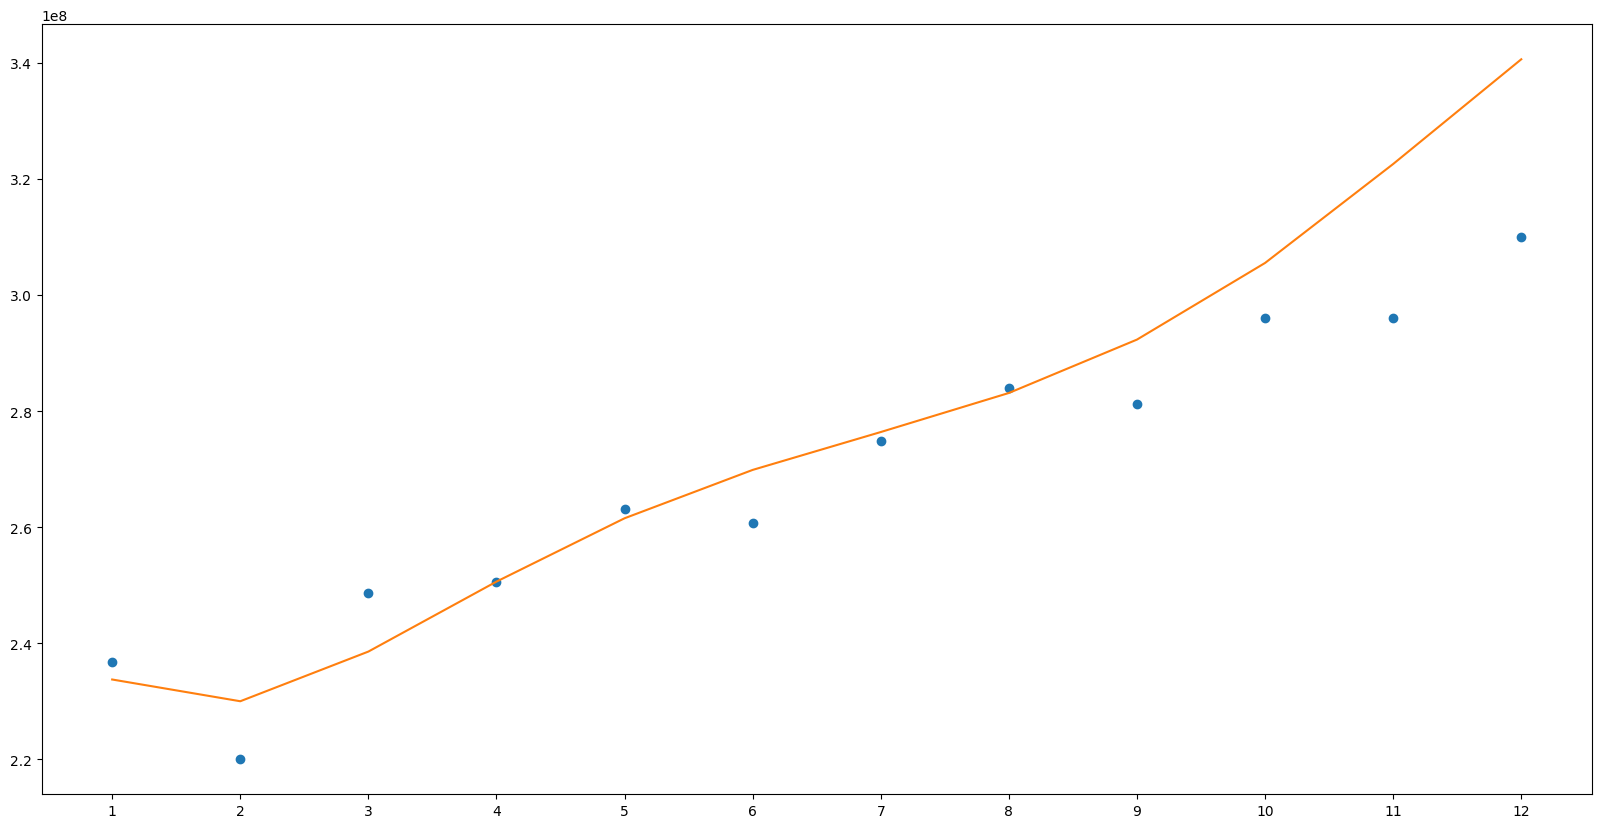

13409309.0


In [33]:

def do_model_normal(degree):
    x = torch.tensor(data.groupby('month')['Receipt_Count'].sum().index, dtype=torch.float32)
    y = torch.tensor(data.groupby('month')['Receipt_Count'].sum().values, dtype=torch.float32)

    x = torch.stack([torch.ones_like(x), x], dim=1)
    # add the x terms for each degree
    
    for i in range(2, degree+1):
        x = torch.cat([x, torch.stack([x[:, 1]**i], dim=1)], dim=1)




    # add a column of ones
    # print(x)
    # calculate the weights
    w = torch.inverse(x.transpose(0, 1) @ x) @ x.transpose(0, 1) @ y
    # plot the data
    plt.plot(x[:, 1], y, 'o')
    plt.plot(x[:, 1], x @ w)
    plt.xticks(range(1, 13))
    plt.show()
    # print the rmse
    print(torch.sqrt(torch.mean((x @ w - y)**2)).item())

do_model_normal(1)



## Testing some other models

### testing increasing the number of features

In [ ]:
do_model_normal(5)

### testing a logarithmic model

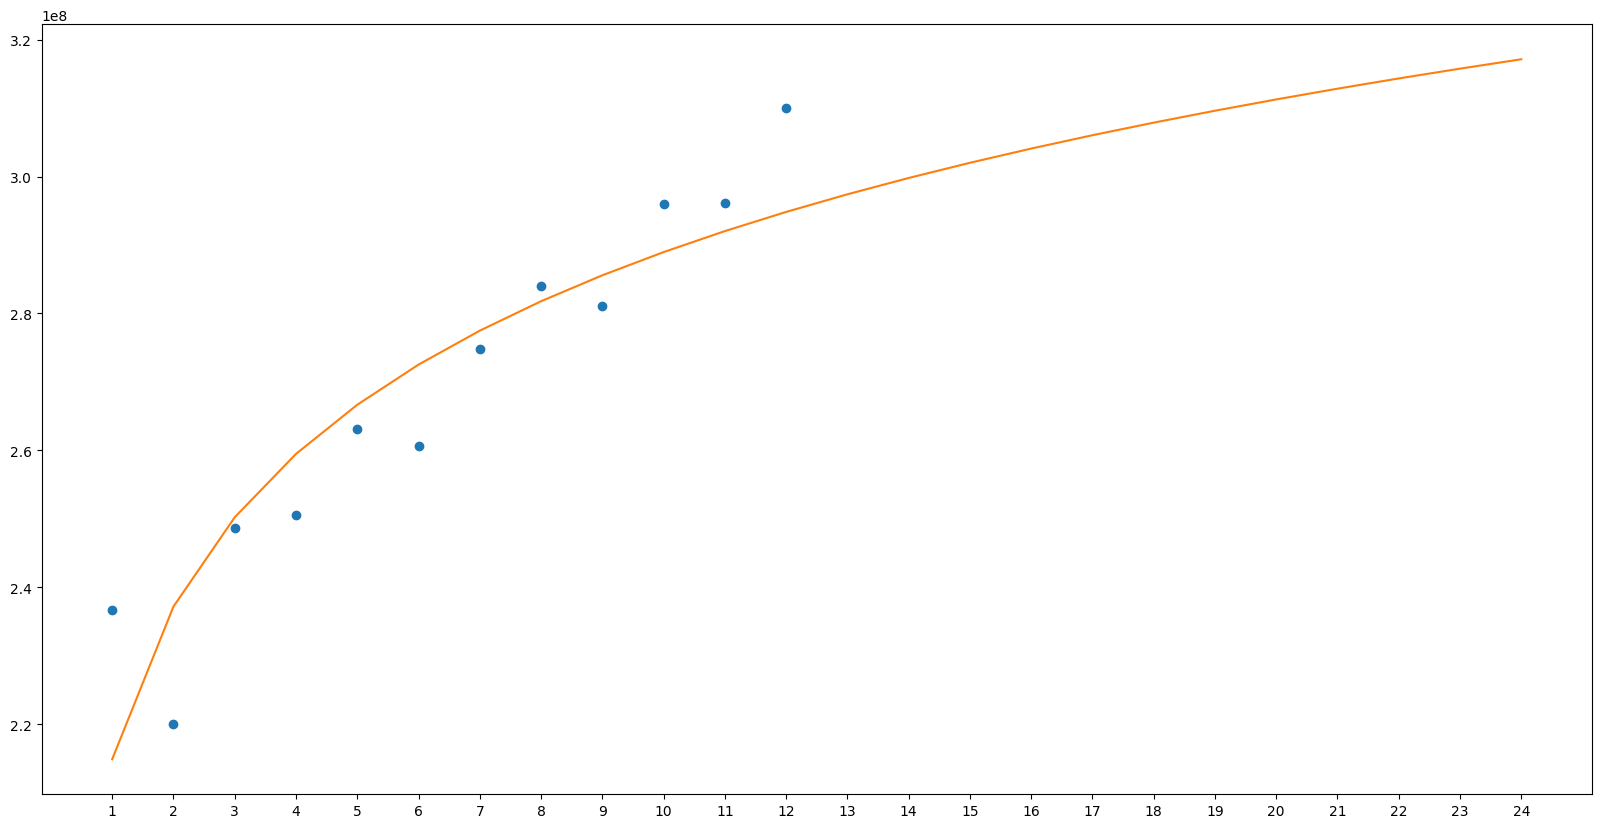

In [67]:
# now do for one constant feature, and one log feature

x = torch.tensor(data.groupby('month')['Receipt_Count'].sum().index, dtype=torch.float32)
y = torch.tensor(data.groupby('month')['Receipt_Count'].sum().values, dtype=torch.float32)

x = torch.stack([torch.ones_like(x), x], dim=1)

# replace the second column with the log of the second column
x[:, 1] = torch.log(x[:, 1])

# add a column of ones
# calculate the weights
w = torch.inverse(x.transpose(0, 1) @ x) @ x.transpose(0, 1) @ y
# plot the data
plt.plot([i for i in range(1,13)], y, 'o')

# plt.plot([i for i in range(1,13)], x @ w)

# make new tensor x with 24 months
x_new = torch.stack([torch.ones(24), torch.tensor([i for i in range(1,25)], dtype=torch.float32)], dim=1)
x_new[:, 1] = torch.log(x_new[:, 1])

plt.plot([i for i in range(1,25)], x_new @ w)

plt.xticks(range(1, 25))
plt.show()

## Conclusions:
### Data Exploration:
- the data shows some weekly trend in the number of reciept scanned
- there is no periodic trend visible for this one year(example: more reciepts in the summer, compared to winter)
- there is primarily a linear growth in reciepts scanned as the months pass
### Model Selection:
- the linear model appears to best fit the data
- adding more featurs leads to overfitting
- a logarithmic model would also make sense, but more data is required to choose whether to choose linear or logarithmic
### Possible Feature Additions:
- USA economy metrics
- prices of specific goods
  - try to find out which reciepts are prominently scanned by fetch app
  - prices of complimentary and substitutes of those goods
- how well fetch complimentary and substitute apps are performing